In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
cantidad_tiradas = 10000
numero_elegido = 11
cantidad_corridas = 10
apuesta_inicial = 5
tipo_capital = 'i'
capital_inicial = 0 if tipo_capital == 'i' else 10000

resultados_rojo = [1, 3, 5, 7, 9, 12, 14, 16,18, 19, 21, 23, 25, 27, 30, 32, 34, 36]
frec_relativa_esperada = 18/37 # apostando al rojo, 18 numeros rojos de 37

serie_fibonacci = [1, 1]
indice_fibonacci = 0

# estrategia = 'f'
estrategia = 'o' # o: otra - en este caso martingala invertida
# estrategia = 'd'
# estrategia = 'm'

In [34]:
estrategias = {
    'f': {
        'title': f'ESTRATEGIA FIBONACCI',
    },
    'm': {
        'title': f'ESTRATEGIA MARTINGALA',
    },
    'd': {
        'title': f'ESTRATEGIA DALEMBERT',
    },
    'o': {
        'title': f'ESTRATEGIA MARGINGALA INVERTIDA',
    },
}

In [35]:
def estrategia_dalembert(ultima_apuesta, is_win, capital):
    unidad = apuesta_inicial
    if is_win:
        capital += ultima_apuesta
        # Evitar apuestas menores que la unidad inicial
        proxima_apuesta = max(ultima_apuesta - unidad, unidad)
    else:
        capital -= ultima_apuesta
        proxima_apuesta = ultima_apuesta + unidad

    return proxima_apuesta, capital

In [36]:
def estrategia_fibonacci(ultima_apuesta, is_win, capital):
    global indice_fibonacci
    if is_win:
        capital += ultima_apuesta
        if indice_fibonacci > 1:
            indice_fibonacci -= 2
        else:
            indice_fibonacci = 0
    else:
        capital -= ultima_apuesta
        indice_fibonacci += 1
        if indice_fibonacci >= len(serie_fibonacci):
            nuevo_valor = serie_fibonacci[-1] + serie_fibonacci[-2]
            serie_fibonacci.append(nuevo_valor)
    
    proxima_apuesta = serie_fibonacci[indice_fibonacci]
    
        

    return proxima_apuesta, capital

In [37]:
def estrategia_martingala(ultima_apuesta, is_win, capital):
    if is_win:
        capital += ultima_apuesta
        proxima_apuesta = apuesta_inicial
    else:
        capital -= ultima_apuesta
        proxima_apuesta = ultima_apuesta * 2

    return proxima_apuesta, capital   

In [38]:
def estrategia_martingala_invertida(ultima_apuesta, is_win, capital):
    unidad = apuesta_inicial
    if is_win:
        capital += ultima_apuesta
        proxima_apuesta = ultima_apuesta + unidad #si gana se aumenta la apuesta
    else:
        capital -= ultima_apuesta
        proxima_apuesta = apuesta_inicial #si pierde se vuelve a la apuesta inicial

    proxima_apuesta = min(proxima_apuesta, capital) #no se apuesta más de lo disponible
    
    return proxima_apuesta, capital


In [39]:
def ejecutar_corrida():
    df = pd.DataFrame()
    df['tiradas'] = np.random.randint(0, 37, cantidad_tiradas)

    wins = []
    frecuencia_relativa = []
    apuestas = []
    flujo_caja = []

    apuestas.append(apuesta_inicial)
    flujo_caja.append(capital_inicial)

    capital = capital_inicial
    for index, tirada in enumerate(df['tiradas']):

        is_win = tirada in resultados_rojo
        wins.append(is_win)

        frecuencia_relativa.append(wins.count(True) / (index + 1))

        if estrategia == 'f':
            proxima_apuesta, capital = estrategia_fibonacci(apuestas[-1], is_win, capital)
        elif estrategia == 'd':
            proxima_apuesta, capital = estrategia_dalembert(apuestas[-1], is_win, capital)
        elif estrategia == 'm':
            proxima_apuesta, capital = estrategia_martingala(apuestas[-1], is_win, capital)
        elif estrategia == 'o':
            proxima_apuesta, capital = estrategia_martingala_invertida(apuestas[-1], is_win, capital)

        if proxima_apuesta > capital and tipo_capital == 'f':  # banca rota
            break

        if len(apuestas) == cantidad_tiradas:
            break

        apuestas.append(proxima_apuesta)
        flujo_caja.append(capital)

    df = pd.DataFrame({
        'flujo_caja': flujo_caja,
        'apuestas': apuestas,
        'wins': wins,
        'frec_rel': frecuencia_relativa
    })
    
    df.index = df.index + 1
    
    return df

In [40]:
def grafico_flujo_caja(corridas):
    plt.figure()
        
    for corrida in corridas:
        sns.lineplot(x=corrida.index, y=corrida['flujo_caja'], alpha=1, linewidth=1, label=None)

    esperado_label = 'Capital inicial'
    plt.axhline(capital_inicial, color='red', linestyle='--', label=f'{esperado_label}') 
    
    title = f'{estrategias[estrategia]['title']} - {cantidad_corridas} CORRIDAS'
    xlabel = 'n (número de tiradas)'
    ylabel = 'c (capital)'
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [41]:
def graficar_histograma(corridas):
    fig, ax = plt.subplots()

    ax.set_xlabel('n (número de tiradas)')
    ax.set_ylabel('fr (frecuencia relativa)')

    for corrida in corridas:
        ax.bar(corrida.index, corrida['frec_rel'], alpha=0.5)

    ax.axhline(frec_relativa_esperada, color='r', linestyle='--', label='fre (frecuencia relativa esperada)')
    ax.legend()

    ax.set_title(f"HISTOGRAMA {estrategias[estrategia]['title']} - {cantidad_corridas} CORRIDAS")
    plt.show()

In [42]:
### MAIN ###
corridas = []
for corrida in range(cantidad_corridas):
    corridas.append(ejecutar_corrida())
corridas

[       flujo_caja  apuestas   wins  frec_rel
 1           10000         5  False  0.000000
 2            9995         5   True  0.500000
 3           10000        10   True  0.666667
 4           10010        15   True  0.750000
 5           10025        20  False  0.600000
 ...           ...       ...    ...       ...
 9996         8615        15  False  0.490296
 9997         8600         5   True  0.490347
 9998         8605        10   True  0.490398
 9999         8615        15  False  0.490349
 10000        8600         5  False  0.490300
 
 [10000 rows x 4 columns],
        flujo_caja  apuestas   wins  frec_rel
 1           10000         5  False  0.000000
 2            9995         5  False  0.000000
 3            9990         5  False  0.000000
 4            9985         5   True  0.250000
 5            9990        10  False  0.200000
 ...           ...       ...    ...       ...
 9996         5605        50  False  0.477291
 9997         5555         5   True  0.477343
 9998

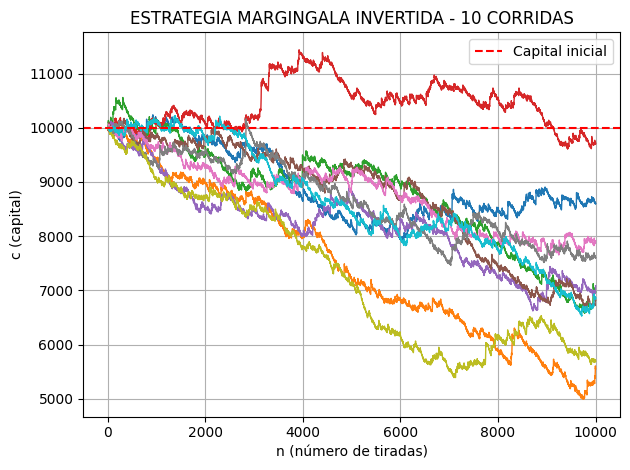

In [43]:
grafico_flujo_caja(corridas)


c:\Users\tomib\OneDrive\Documentos\simulacion\simulacion-tps-2025\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


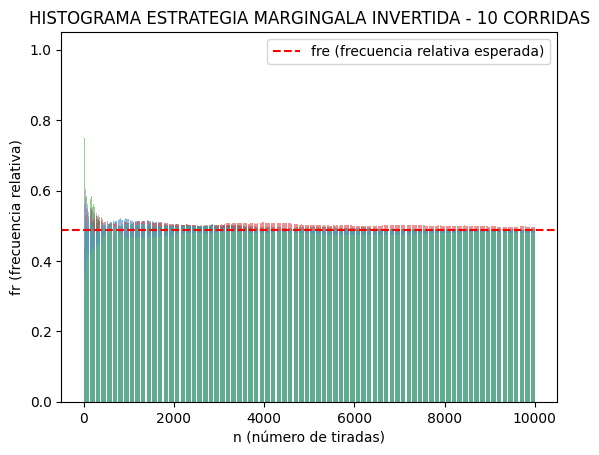

In [44]:
graficar_histograma(corridas)

In [45]:
corridas[0]

,flujo_caja,apuestas,wins,frec_rel
1,10000,5,False,0.000000
2,9995,5,True,0.500000
3,10000,10,True,0.666667
4,10010,15,True,0.750000
5,10025,20,False,0.600000
...,...,...,...,...
9996,8615,15,False,0.490296
9997,8600,5,True,0.490347
9998,8605,10,True,0.490398
9999,8615,15,False,0.490349


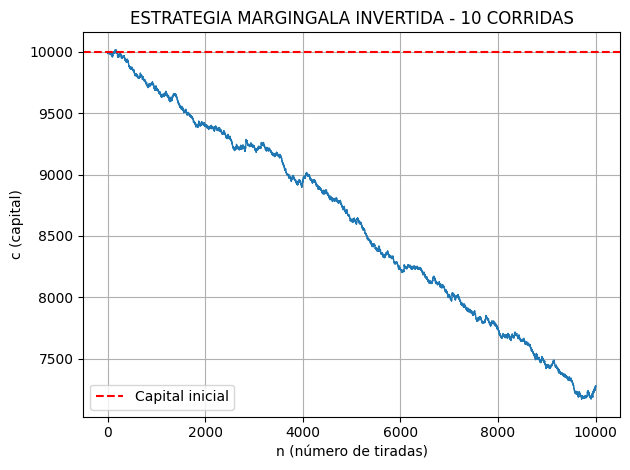

In [46]:
df_promedio_list = []
df_promedio = pd.concat(corridas).groupby(level=0).mean()
df_promedio_list.append(df_promedio)
grafico_flujo_caja(df_promedio_list)


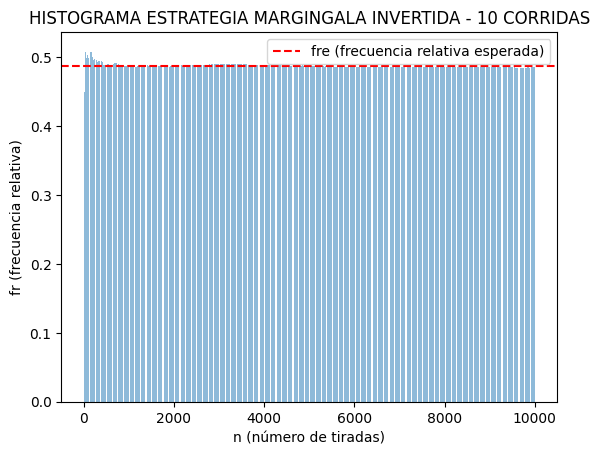

In [47]:
graficar_histograma(df_promedio_list)